In [119]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn.grid_search import ParameterGrid
from sklearn.preprocessing import LabelEncoder

from data_reader import read_data
from data_preprocessing import preprocess_data
from feature_extractor import extract_features

%matplotlib inline

In [120]:
data = read_data()
data = preprocess_data(data, limit=10000)
data.head()

,id,Title,Uri,PublicationDateTimeUTC,ProcedureDisplayName,Amount,RubPrice,CurrencyCode,StatusDisplayName,StatusCode,SuppliersCount,IsWinner,Inn,Kpp,Name,Ogrn,ResultClass,Ogrn1
0,0100600000117000008,услуги по капитальному ремонту,https://zakupki.kontur.ru/0100600000117000008,2017-07-27,Закупка у единственного поставщика (подрядчика...,352000.00,352000.00,RUB,Размещение отменено,3.0,0.0,0.0,4720008346,NaN,МЕСТНАЯ АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАН...,1024702184451,2.0,47
1,0101100000116000162,Масло сладко-сливочное несоленое Крестьянское,https://zakupki.kontur.ru/0101100000116000162,2016-10-24,Электронный аукцион,3855260.00,3855260.00,RUB,Размещение отменено,3.0,0.0,0.0,0275006455,NaN,УПРАВЛЕНИЕ ФЕДЕРАЛЬНОЙ СЛУЖБЫ ИСПОЛНЕНИЯ НАКАЗ...,1020202776714,2.0,2
2,0101100000117000153,Индивидуальный рацион питания для повседневной...,https://zakupki.kontur.ru/0101100000117000153,2017-09-25,Электронный аукцион,3600000.00,3600000.00,RUB,Размещение отменено,3.0,0.0,0.0,0275006455,NaN,УПРАВЛЕНИЕ ФЕДЕРАЛЬНОЙ СЛУЖБЫ ИСПОЛНЕНИЯ НАКАЗ...,1020202776714,2.0,2
3,0101100000117000154,Консервы мясные,https://zakupki.kontur.ru/0101100000117000154,2017-09-25,Электронный аукцион,15400000.00,15400000.00,RUB,Размещение отменено,3.0,0.0,0.0,0275006455,NaN,УПРАВЛЕНИЕ ФЕДЕРАЛЬНОЙ СЛУЖБЫ ИСПОЛНЕНИЯ НАКАЗ...,1020202776714,2.0,2
4,0101100000416000025,Право заключения государственного контракта на...,https://zakupki.kontur.ru/0101100000416000025,2016-05-30,Открытый конкурс,79196.94,79196.94,RUB,Размещение отменено,3.0,0.0,0.0,0278103383,NaN,УПРАВЛЕНИЕ ФЕДЕРАЛЬНОЙ СЛУЖБЫ ПО НАДЗОРУ В СФЕ...,1040204605154,2.0,2


In [121]:
# def GetBalancedSample(data, count):
#     cancel_count = min(count // 3, data[data.ResultClass == 2].shape[0])
#     success_count = min((count - cancel_count) // 2, data[data.ResultClass == 1].shape[0])
#     unsuccess_count = count - cancel_count - success_count
#     balanced_sample = pd.concat([data[data.ResultClass == 2][:cancel_count],
#                                  data[data.ResultClass == 1][:success_count],
#                                  data[data.ResultClass == 0][:unsuccess_count]])
#     print(balanced_sample.groupby('ResultClass').size())
#     return balanced_sample

# GetBalancedSample(data, 10000)

In [122]:
data.groupby('ResultClass').size()

ResultClass
0.0    3334
1.0    3333
2.0    3333
dtype: int64

In [123]:
data.corr()

,Amount,RubPrice,StatusCode,SuppliersCount,IsWinner,ResultClass,Ogrn1
Amount,1.000000,1.000000,0.049623,-0.007320,-0.008976,0.049587,0.002860
RubPrice,1.000000,1.000000,0.049623,-0.007320,-0.008976,0.049587,0.002860
StatusCode,0.049623,0.049623,1.000000,-0.397528,-0.456661,0.866025,0.476021
SuppliersCount,-0.007320,-0.007320,-0.397528,1.000000,0.811654,-0.006131,-0.152609
IsWinner,-0.008976,-0.008976,-0.456661,0.811654,1.000000,0.033552,-0.164021
ResultClass,0.049587,0.049587,0.866025,-0.006131,0.033552,1.000000,0.438440
Ogrn1,0.002860,0.002860,0.476021,-0.152609,-0.164021,0.438440,1.000000


In [124]:
data_head = data
features = extract_features(data_head)[0]

oh CurrencyCode
oh ProcedureDisplayName
oh Ogrn
ng Title
ng ProcedureDisplayName
ng OrgName


In [125]:
features = pd.DataFrame(features)

In [126]:
features.fillna(0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(features.drop('ResultClass', axis=1).values,
                            features.ResultClass.values,
                            test_size=0.3,
                            random_state=123456)

In [127]:
# features = pd.DataFrame(features)
# X_train = features.drop(['ResultClass'], 1)
# y_train = features.ResultClass

In [128]:
# rf = RF(n_estimators=10, n_jobs=-1)
# rf = rf.fit(x_train, y_train)
# np.mean(cross_val_score(rf, x_train, y_train))

In [129]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, label=y_test, reference=lgb_train, free_raw_data=False)

In [130]:
params = {
        'objective': 'multiclass',
        'metric': 'multi_error',
        'num_classes': 3,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 123456,
        'bagging_fraction': 0.9,
        'bagging_freq': 1,
        'bagging_seed': 123456,
        'max_depth': 8,
        'learning_rate': 0.1,
        'min_data_in_leaf': 11,
        'num_iteration': 100,
        'num_threads': 2
    }

In [131]:
gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_eval])  # eval training data
#                     feature_name=features.drop('ResultClass', axis=1).columns.values)

gbm.save_model(f'result.txt')

C:\anaconda3\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_error: 0.0791429	valid_1's multi_error: 0.105667
[2]	training's multi_error: 0.073	valid_1's multi_error: 0.102667
[3]	training's multi_error: 0.0688571	valid_1's multi_error: 0.1
[4]	training's multi_error: 0.0714286	valid_1's multi_error: 0.0976667
[5]	training's multi_error: 0.0698571	valid_1's multi_error: 0.102
[6]	training's multi_error: 0.064	valid_1's multi_error: 0.098
[7]	training's multi_error: 0.0612857	valid_1's multi_error: 0.0943333
[8]	training's multi_error: 0.0622857	valid_1's multi_error: 0.0966667
[9]	training's multi_error: 0.0591429	valid_1's multi_error: 0.0926667
[10]	training's multi_error: 0.0574286	valid_1's multi_error: 0.094
[11]	training's multi_error: 0.0555714	valid_1's multi_error: 0.0916667
[12]	training's multi_error: 0.0555714	valid_1's multi_error: 0.0906667
[13]	training's multi_error: 0.0545714	valid_1's multi_error: 0.0936667
[14]	training's multi_error: 0.0541429	valid_1's multi_error: 0.091
[15]	training's multi_error: 0.05

In [132]:
num_round = 12
lgb.cv(params, lgb_train, num_round, nfold=5)

{'multi_error-mean': [0.094571897770292998,
  0.093142202653413539,
  0.092285466503265245,
  0.086426585964267749,
  0.087856687788141791,
  0.087712504477491487,
  0.0881425037506047,
  0.086712911621492139,
  0.085570461622635624,
  0.084427807833275775,
  0.084284135528405163,
  0.083999746099465783],
 'multi_error-stdv': [0.0078525462477377315,
  0.0055321708320201935,
  0.0037566893193274587,
  0.0054637108036542066,
  0.0029483854732306608,
  0.0033749924479041992,
  0.0021799606942215759,
  0.0030103491501607006,
  0.0031491924351767786,
  0.003122618610625163,
  0.0044866421646252855,
  0.0040513004360489286]}

In [133]:
# fit model no training data
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
np.mean(cross_val_score(xgb, X_train, y_train, cv=5))

0.91642627860332282

In [134]:
from sklearn.ensemble import RandomForestClassifier as RF

rf = RF(n_estimators=200, max_features='auto', n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [135]:
def get_metric(X_test, y_test, model):
    y_pred = None
    if "predict_proba" in dir(model):
        y_pred = model.predict_proba(X_test)
    else:
        y_pred = model.predict(X_test)
    test = pd.DataFrame(y_test, columns=['test'])
    test['prediction'] = [np.argmax(x) for x in y_pred]
    print(classification_report(y_test, test['prediction'].values))
    test['is_same'] = test.apply(lambda row: int(row[0] == row[1]), axis=1)
    f = {'is_same': ['sum', 'size', 'mean']}
    groups = test.groupby('test').agg(f)
    print(sum(test['is_same']) / test.shape[0])
    return groups['is_same'].sort_values('mean', ascending=False)

In [136]:
def transform_to_one_vs_rest(y_test, y_pred_proba, index):
    y_test_i = np.array(list(map(lambda e: 1 if e == index else 0, y_test)))
    y_pred_proba_i = np.array(list(map(lambda probas: probas[index], y_pred_proba)))
    return y_test_i, y_pred_proba_i

In [137]:
def get_roc_auc(X_test, y_test, model):
    y_pred = None
    if "predict_proba" in dir(model):
        y_pred = model.predict_proba(X_test)
    else:
        y_pred = model.predict(X_test)
    for i in range(3):
        y_test_i, y_pred_i = transform_to_one_vs_rest(y_test, y_pred, i)
        fpr, tpr, _ = roc_curve(y_test_i,  y_pred_i)
        auc = roc_auc_score(y_test_i, y_pred_i)
        plt.plot(fpr, tpr, label=f'class {i}, auc={auc}')
        plt.legend(loc=4)
        plt.show()

In [138]:
get_metric(X_test, y_test, gbm)

             precision    recall  f1-score   support

        0.0       0.90      0.92      0.91       988
        1.0       0.86      0.90      0.88       987
        2.0       0.99      0.94      0.96      1025

avg / total       0.92      0.92      0.92      3000

0.918666666667


,sum,size,mean
test,,,
2.0,959,1025,0.935610
0.0,908,988,0.919028
1.0,889,987,0.900709


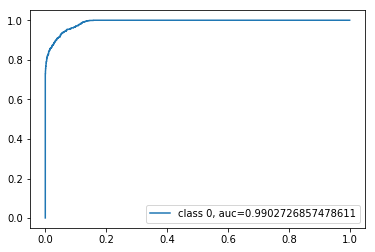

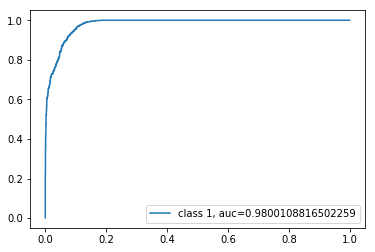

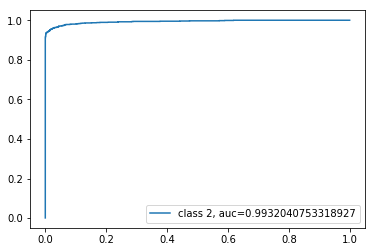

In [139]:
get_roc_auc(X_test, y_test, gbm)

In [140]:
get_metric(X_test, y_test, xgb)

             precision    recall  f1-score   support

        0.0       0.90      0.90      0.90       988
        1.0       0.84      0.90      0.87       987
        2.0       0.99      0.93      0.96      1025

avg / total       0.91      0.91      0.91      3000

0.908333333333


,sum,size,mean
test,,,
2.0,952,1025,0.928780
0.0,887,988,0.897773
1.0,886,987,0.897670


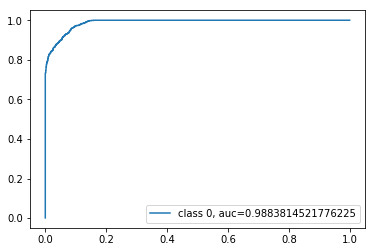

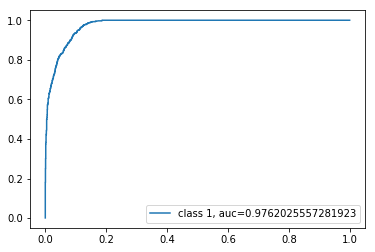

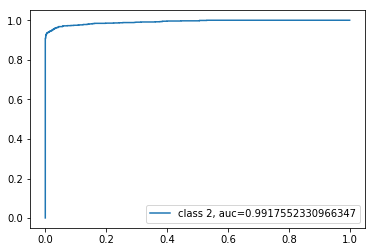

In [141]:
get_roc_auc(X_test, y_test, xgb)

In [142]:
get_metric(X_test, y_test, rf)

             precision    recall  f1-score   support

        0.0       0.92      0.90      0.91       988
        1.0       0.85      0.92      0.88       987
        2.0       0.98      0.93      0.96      1025

avg / total       0.92      0.92      0.92      3000

0.918


,sum,size,mean
test,,,
2.0,956,1025,0.932683
1.0,907,987,0.918946
0.0,891,988,0.901822


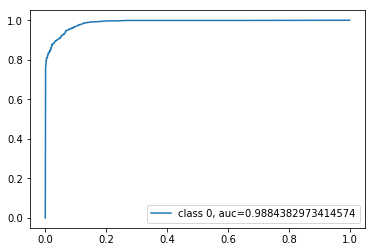

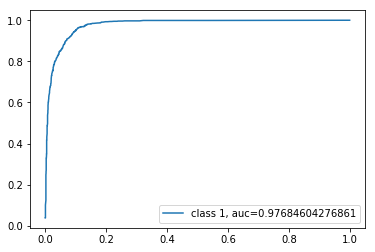

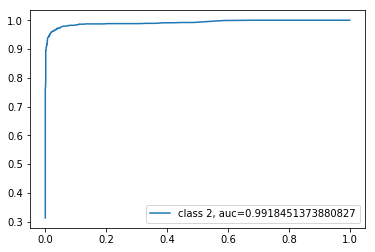

In [143]:
get_roc_auc(X_test, y_test, rf)

In [144]:
features = extract_features(data_head, onehot_encode=False)[0]
features = pd.DataFrame(features)
features.fillna(0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(features.drop('ResultClass', axis=1).values,
                            features.ResultClass.values,
                            test_size=0.3,
                            random_state=123456)

ng Title
ng ProcedureDisplayName
ng OrgName


In [145]:
cat_features = ['CurrencyCode', 'ProcedureDisplayName', 'Ogrn1']
features[cat_features].head()

,CurrencyCode,ProcedureDisplayName,Ogrn1
0,0,2,12
1,0,13,0
2,0,13,0
3,0,13,0
4,0,9,0


In [146]:
cats = np.where(features.dtypes != np.float)[0]
cats

array([3, 4, 5], dtype=int64)

In [147]:
model = CatBoostClassifier(iterations=100, depth=10, learning_rate=.1, loss_function='MultiClass', classes_count=3,
                           logging_level='Silent')
model.fit(X_train, y_train, cat_features=cats)

In [148]:
get_metric(X_test, y_test, model)

             precision    recall  f1-score   support

        0.0       0.92      0.91      0.91       988
        1.0       0.85      0.92      0.88       987
        2.0       1.00      0.92      0.96      1025

avg / total       0.92      0.92      0.92      3000

0.917


,sum,size,mean
test,,,
2.0,946,1025,0.922927
1.0,908,987,0.919959
0.0,897,988,0.907895


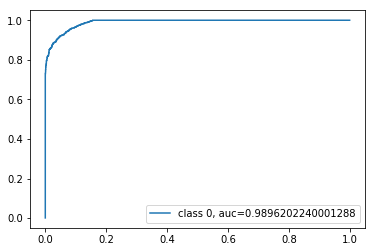

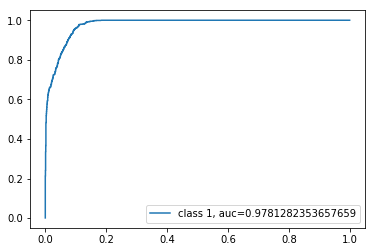

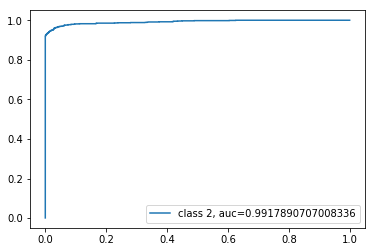

In [149]:
get_roc_auc(X_test, y_test, model)

In [150]:
def cross_val(X, y, X_test, param, cat_features, n_splits=3):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    acc = []
    predict = None
    
    for tr_ind, val_ind in skf.split(X, y):
        X_train = X[tr_ind]
        y_train = y[tr_ind]
        
        X_valid = X[val_ind]
        y_valid = y[val_ind]
        
        clf = CatBoostClassifier(iterations=100, loss_function=param['loss_function'], depth=param['depth'],
                                 l2_leaf_reg=param['l2_leaf_reg'], eval_metric='Accuracy', leaf_estimation_iterations=10,
                                 use_best_model=True, logging_level='Silent', learning_rate=param['learning_rate'],
                                 classes_count=3)
        
        clf.fit(X_train, 
                y_train,
                cat_features=cat_features,
                eval_set=(X_valid, y_valid)
        )
        
        y_pred = clf.predict(X_valid)
        accuracy = accuracy_score(y_valid, y_pred)
        acc.append(accuracy)
    return sum(acc)/n_splits
    
def catboost_GridSearchCV(X, y, X_test, params, cat_features, n_splits=5):
    ps = {'acc':0,
          'param': []
    }
    
    predict=None
    grid = list(ParameterGrid(params))
    l = len(grid)
    for i, prms in enumerate(grid):
                          
        acc = cross_val(X, y, X_test, prms, cat_features, n_splits=5)
        print(f'{i}/{l}')
        if acc>ps['acc']:
            ps['acc'] = acc
            ps['param'] = prms
    print('Acc: '+str(ps['acc']))
    print('Params: '+str(ps['param']))
    
    return ps['param']

In [151]:
params = {
    'depth':[7, 9],
    'loss_function': ['MultiClass', 'MultiClassOneVsAll'],
    'l2_leaf_reg':np.logspace(-20, -19, 3),
    'learning_rate': [0.1, 0.5, 1]
}
    
# param = catboost_GridSearchCV(X_train, y_train, X_test, params, cats)
# param

In [152]:
model = CatBoostClassifier(iterations=500, depth=7, learning_rate=.1, loss_function='MultiClass', classes_count=3,
                           logging_level='Silent', leaf_estimation_iterations=10)
model.fit(X_train, y_train, cat_features=cats)

In [153]:
get_metric(X_test, y_test, model)

             precision    recall  f1-score   support

        0.0       0.91      0.92      0.92       988
        1.0       0.86      0.91      0.88       987
        2.0       0.99      0.93      0.96      1025

avg / total       0.92      0.92      0.92      3000

0.920333333333


,sum,size,mean
test,,,
2.0,956,1025,0.932683
0.0,910,988,0.921053
1.0,895,987,0.906788


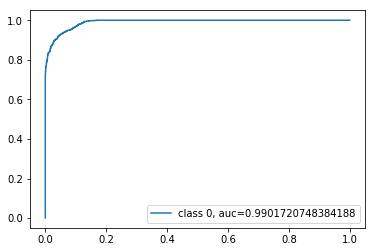

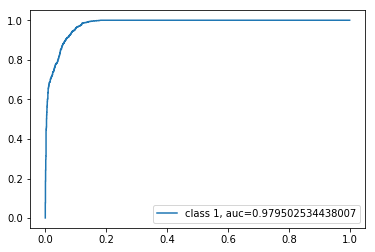

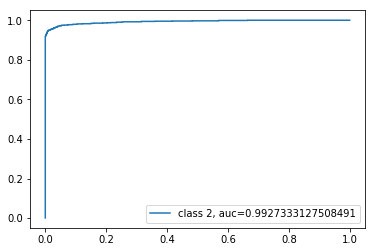

In [154]:
get_roc_auc(X_test, y_test, model)

In [155]:
model = CatBoostClassifier(iterations=1000, depth=7, learning_rate=.1, loss_function='MultiClass', classes_count=3,
                           logging_level='Silent', leaf_estimation_iterations=10)
model.fit(X_train, y_train, cat_features=cats)
get_metric(X_test, y_test, model)

             precision    recall  f1-score   support

        0.0       0.90      0.92      0.91       988
        1.0       0.86      0.89      0.88       987
        2.0       0.99      0.94      0.96      1025

avg / total       0.92      0.92      0.92      3000

0.916


,sum,size,mean
test,,,
2.0,959,1025,0.935610
0.0,908,988,0.919028
1.0,881,987,0.892604


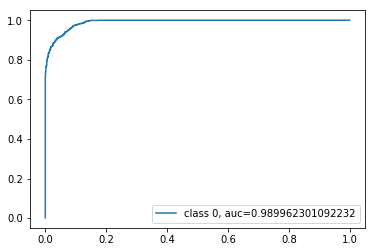

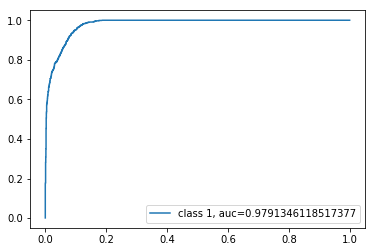

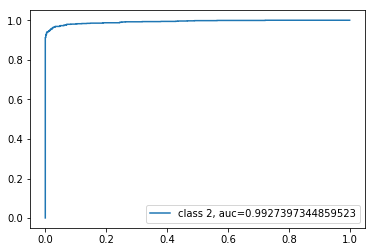

In [156]:
get_roc_auc(X_test, y_test, model)